<a href="https://colab.research.google.com/github/eipisuraj/pytorch/blob/main/01_PyTorchWorkflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch WorkFlow

In [1]:
what_were_covering = {1: "Data (Prepare and Load ",
                      2: "Building a Model",
                      3: "Fitting a mode to data (Training)",
                      4:"Making predictions and evaluating a model (inference)",
                      5: "Saving and loading a model",
                      6:"Putting all together"}

In [2]:
# Importing torch
import torch
from torch import nn
import matplotlib.pyplot as plt

# Check torch version
print(torch.__version__)

2.8.0+cu126


## 1.Data (Preparing and Loading)

Any sort of data for example excel spredsheet,images,videos,audio,dna,text

Main two parts of ML:
1. Get data into a numerical representation
2. Build a model to learn patterns in that numerical represntation

We're using linear Regression formula to make a straight line with *known* **parameters**

In [3]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create
start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1)
# unsqueeze added an extra dimension
y = weight * X + bias

X[:10],y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Spilitting data into training and test sets

In [4]:
# Create a train test split
train_split = int(0.8 * len(X))
X_train,y_train = X[:train_split],y[:train_split]
X_test,y_test = X[train_split:],y[train_split:]

len(X_train),len(y_train),len(X_test),len(y_test)

(40, 40, 10, 10)

In [5]:
def plot_predictions(train_data = X_train,
                     train_label = y_train,
                     test_data = X_test,
                     test_label = y_test,
                     predictions = None):
  """
  Plots training data, tets data and compares predictions .
  """
  plt.figure(figsize=(10,7))

  # Plotting training data
  plt.scatter(train_data,train_label,c="b",s=4, label="Training Data")

  # Plotting test data
  plt.scatter(test_data,test_label,c="g",s=4,label="Test Data")

  # Are there predictions
  if predictions is not None:
    # Plot the predictions if they exist
    plt.scatter(test_data,predictions,c="r",s=4,label="Predictions")
  # Show legends
  plt.legend(prop={"size":14})


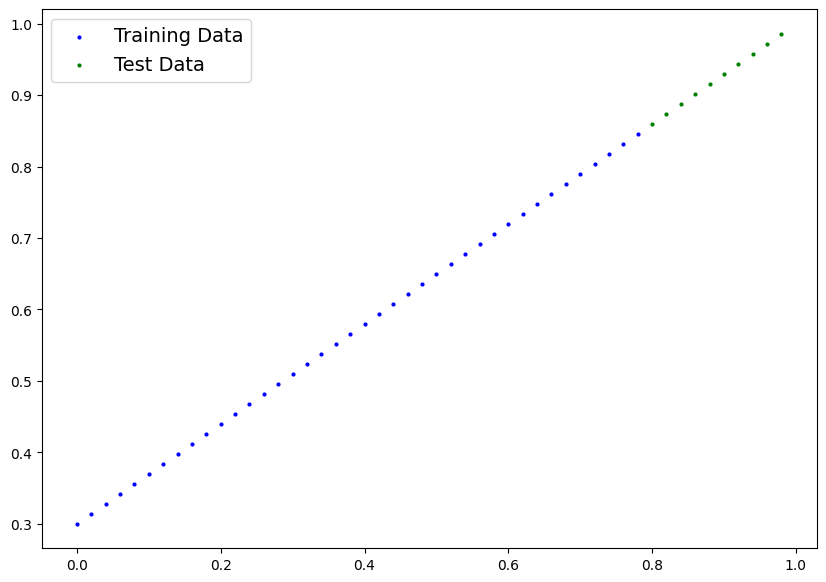

In [6]:
plot_predictions();

## 2.Building First PyTorch Model

What our model does
* Start with Random Values
* Look at training data and adjust the random values to better represent (or get closer to ideal values) that is to weight and bias values

**Through 2 main Algorithms**
1. Gradient Descent
2. Backpropagation

In [7]:
# Create a linear regression model class
# Almost everything in pytorch inherits from nn.module
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Initialize Model Parameters
    self.weights = nn.Parameter(torch.randn(1,
                                            requires_grad=True,
                                            dtype=torch.float))
    self.bias = nn.Parameter(torch.randn(1,
                                         requires_grad=True,
                                         dtype=torch.float))

  # Forward Method to define the computation in the model
  # that is forward() defines the computation in the model
  def forward(self,x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias # This is linear regression formula


### PyTorch model Building essentials

1. torch.nn
2. torch.nn.Parameter
3. torch.nn.Module
4. torch.optim
5. def forward()


### Checking the contents of our PyTorch Model

We can check our model parameters or whats inside our model using`.parameters()`


In [8]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of a model
model_0 = LinearRegressionModel()

# Check out the Parameters
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [9]:
# List named Parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`
Checking models predictive power seeing how well it predicts `y_test` based on `x_test`

When we pass data through the model, its going to run it through `forward()` method

In [10]:
y_preds = model_0(X_test)
y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]], grad_fn=<AddBackward0>)

In [11]:
# Making predictions with model ie. during infernece mode there ain't no
# backtracking going on

with torch.inference_mode():
  y_preds = model_0(X_test)

# with torch.no_grad(): # This might be also used but inference_mode() is preffered
#   y_preds = model_0(X_test)

y_preds

tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])

In [12]:
y_test

tensor([[0.8600],
        [0.8740],
        [0.8880],
        [0.9020],
        [0.9160],
        [0.9300],
        [0.9440],
        [0.9580],
        [0.9720],
        [0.9860]])

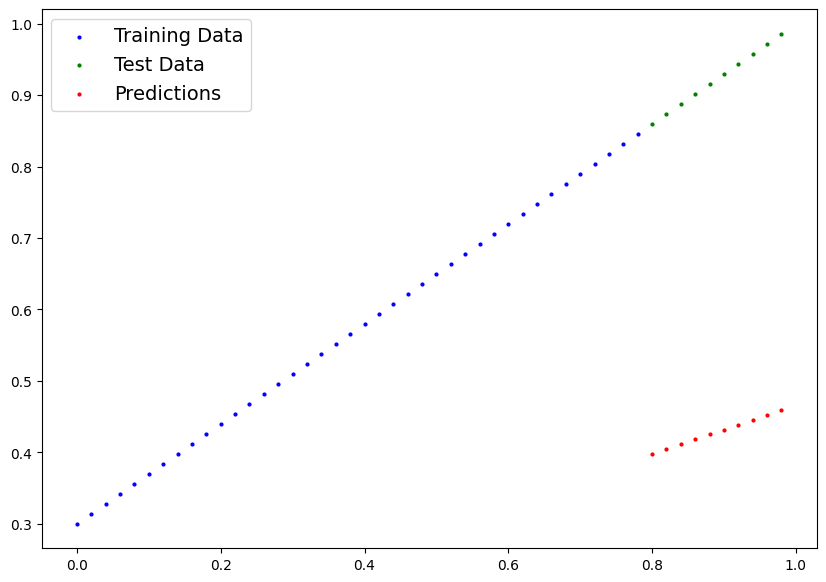

In [13]:
plot_predictions(predictions=y_preds)

## 3.Train Model

Moving model from poor represntation of data to a better representation of data

* **`Loss Function`** : A function to measure how wrong your models prediction are to the ideal outputs (also known as `cost function`)

* **`Optimizer`** : Takes into account loss of a model and adjust the models's parameters(`weight` amd `bias`)

And specifically for PyTorch, we need:
* A Training loop
* A Testing loop

In [14]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [15]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an optimizer (Stochiastic Gradient Descent)
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01) # learning rate is most important hyperparameter here

### Building a training loop and testing loop in PyTorch

A. Training loop

0. Loop through the data
1. Forward pass (Involves data moving through our models's `forward()` functions) to make predictions on data - also known as `forward propogation`
2. Calculate the `loss` (compare forward pass predictions to ground truth labels)
3. Optimizer zero grad
4. Loss backward - move backward through the network to calculate the gradients of each of the parameters of our model wrt `loss` (known as **`backpropogation`**)
5. Optimizer step - Use optimizer to adjust our model's parameters to try and improve the loss (**`gradient descent`**)

look for :
torch autograd and learning rate scheduling

In [16]:
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [17]:
# Setup a random seed
torch.manual_seed(42)

# An epoch is one loop through the data (epochs an hyperparameter)
epochs = 200
epoch_values = []
loss_values = []
test_loss_values = []

# 0.Loop through the data
for epoch in range(epochs):
  # Set model to training mode
  model_0.train()

  # 1.Forward pass
  y_preds = model_0(X_train)

  # 2.Calculate the loss
  loss = loss_fn(y_preds,y_train)
  # print(f"loss:{loss}")

  # 3.Optimizer zero grad
  optimizer.zero_grad()

  # 4. Perform backpropogation on the loss with respect to he parameters of the model
  loss.backward()

  # 5. Step the optimizer (perform gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval() # turns off diffrent settings in the model not needed for evaluating/testing(dropout/batch norm layers)
  with torch.inference_mode():
    #1.Do the forward
    test_pred = model_0(X_test)

    #2. Calculate the loss
    test_loss = loss_fn(test_pred,y_test)
  if epoch % 10 == 0:
    epoch_values.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    print(f"Epoch: {epoch} | Loss: {loss} | Test loss: {test_loss}")
# Print model state_dict
print(model_0.state_dict())


Epoch: 0 | Loss: 0.31288138031959534 | Test loss: 0.48106518387794495
Epoch: 10 | Loss: 0.1976713240146637 | Test loss: 0.3463551998138428
Epoch: 20 | Loss: 0.08908725529909134 | Test loss: 0.21729660034179688
Epoch: 30 | Loss: 0.053148526698350906 | Test loss: 0.14464017748832703
Epoch: 40 | Loss: 0.04543796554207802 | Test loss: 0.11360953003168106
Epoch: 50 | Loss: 0.04167863354086876 | Test loss: 0.09919948130846024
Epoch: 60 | Loss: 0.03818932920694351 | Test loss: 0.08886633068323135
Epoch: 70 | Loss: 0.03476089984178543 | Test loss: 0.0805937647819519
Epoch: 80 | Loss: 0.03132382780313492 | Test loss: 0.07232122868299484
Epoch: 90 | Loss: 0.02788739837706089 | Test loss: 0.06473556160926819
Epoch: 100 | Loss: 0.024458957836031914 | Test loss: 0.05646304413676262
Epoch: 110 | Loss: 0.021020207554101944 | Test loss: 0.04819049686193466
Epoch: 120 | Loss: 0.01758546568453312 | Test loss: 0.04060482233762741
Epoch: 130 | Loss: 0.014155393466353416 | Test loss: 0.03233227878808975
Ep

In [18]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [19]:
with torch.inference_mode():
  y_preds_new = model_0(X_test)

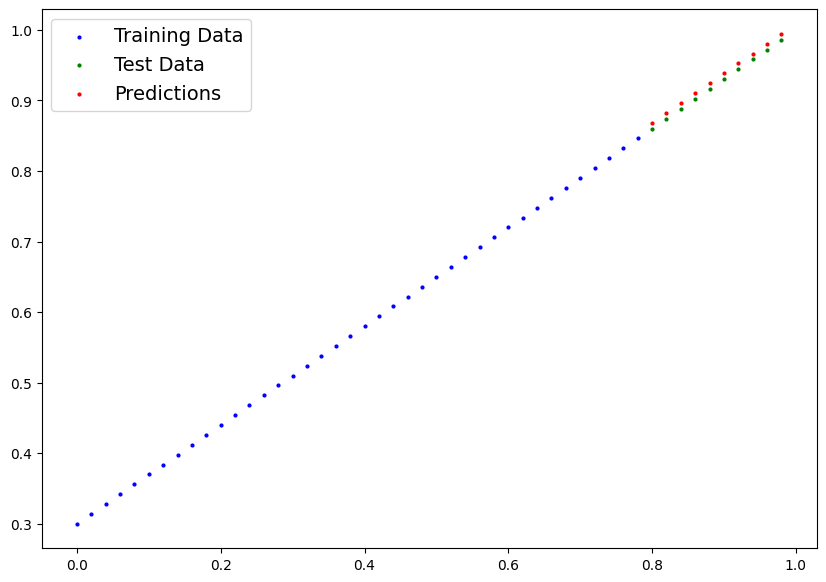

In [20]:
plot_predictions(predictions=y_preds_new)

/tmp/ipython-input-1307812872.py:3: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  plt.plot(epoch_values,np.array(torch.tensor(loss_values).numpy()),label="Train loss values")


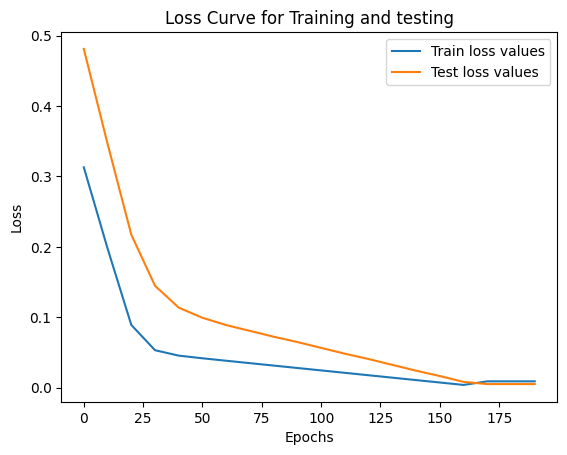

In [21]:
# Plot the loss curves
import numpy as np
plt.plot(epoch_values,np.array(torch.tensor(loss_values).numpy()),label="Train loss values")
plt.plot(epoch_values,np.array(torch.tensor(test_loss_values).numpy()),label="Test loss values")
plt.title("Loss Curve for Training and testing")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend();


In [22]:
type(loss)

torch.Tensor

## 4.Saving and Loading model


### Saving

In [23]:
# Saving a PyTorch model
from pathlib import Path

# 1.Create a model Directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2.Create a model save path
MODEL_NAME = "01_pytorch_linreg.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
MODEL_SAVE_PATH

# 3.Saving model tp stste dict
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),f=MODEL_SAVE_PATH)

Saving model to : models/01_pytorch_linreg.pth


In [24]:
!ls -1 models

01_pytorch_linreg.pth


### Loading

In [25]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

In [26]:
# To load in a saved state_dict we have to instantiate a new instance of our model
loaded_model_0 = LinearRegressionModel()

# Load the model_0
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [27]:
loaded_model_0.state_dict()

OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

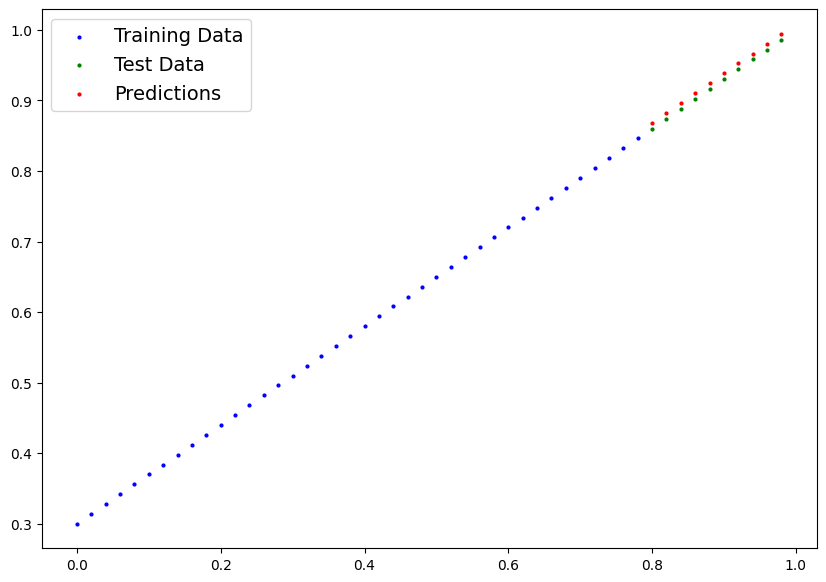

In [28]:
# make some predictions with our loaded mode
loaded_model_0.eval()

with torch.inference_mode():
  loaded_model_preds = loaded_model_0(X_test)

plot_predictions(predictions=loaded_model_preds)

In [29]:
# Checking if model_0 and loaded_model_0 provide same results
model_0.eval()
with torch.inference_mode():
  y_preds = model_0(X_test)

y_preds==loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

## 6.Putting it all together

Putting all the steps at one place

In [30]:
# Import tools required
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

# See PyTorch version
print(torch.__version__)

2.8.0+cu126


Creating a device agnoistic code

Means that if we've got accesss to GPU , our code will use it , if no GPU is available, the code will default to using cpu

In [31]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Currently Running on a : {device}")

Currently Running on a : cuda


In [32]:
!nvidia-smi

Mon Sep 15 09:17:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 6.1 Data

In [33]:
#Creating some data using linear regression of y = weight * X + bias
weight = 0.7
bias = 0.3

# Craeting rane values
start = 0
end = 1
step = 0.02

# Create X and y(features and labels)
X = torch.arange(start,end,step).unsqueeze(dim=1)
y = weight * X + bias


In [34]:
# Split data
train_split = int(0.8*len(X))
X_train, X_test, y_train, y_test = X[:train_split],X[train_split:],y[:train_split],y[train_split:]
len(X_train),len(X_test),len(y_train),len(y_test)

(40, 10, 40, 10)

In [35]:
# Defining plotting function
def plot_predictions(train_data=X_train,
                     train_label=y_train,
                     test_data=X_test,
                     test_label=y_test,
                     predictions=None):
  """
  Function to plot Predictions
  """
  plt.figure(figsize=(10,7))

  plt.scatter(train_data,train_label,c="b",s=5,label="Train Data")
  plt.scatter(test_data,test_label,c="r",s=5,label="Test Data")

  if predictions is not None:
    plt.scatter(test_data,predictions,c="g",s=5,label="Predictions")
  plt.legend(prop={"size":14})


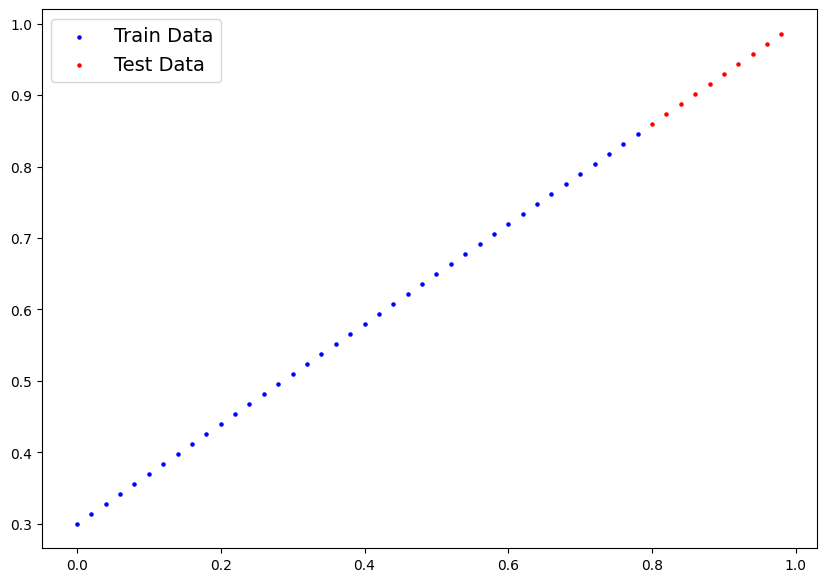

In [36]:
plot_predictions()

### 6.2 Building a PyTorch Linear Model

In [37]:
# Creating a linear model by subclassing nn.Module
class LinearRegressionModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    # Use nn.Linear() for creating the model parematers
    self.linear_layer = nn.Linear(in_features=1,
                                  out_features=1)

  def forward(self,x: torch.Tensor)->torch.Tensor:
    return self.linear_layer(x)

 # Set the manula seed
torch.manual_seed(42)
model_1 = LinearRegressionModelV2()
model_1


LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [38]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

### 6.3 Training a Model

We gonna need
* Loss Function
* Optimizer
* Training Loop
* Testing Loop

In [39]:
# Check The model current device
next(model_1.parameters()).device

device(type='cpu')

In [40]:
# Set the model to use the te=arget device
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [41]:
# Setup a loss function
loss_fn = nn.L1Loss()

# Setup an Optimizer
optimizer = torch.optim.SGD(params=model_1.parameters(),
                        lr=0.01)

In [43]:
# Writing Training loop
torch.manual_seed(42)

# Setup a device agnoistic code
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

epochs = 200
for epoch in range(epochs):
  model_1.train()

  # 1. Forward Pass
  y_preds = model_1(X_train)

  # 2. Loss
  loss = loss_fn(y_preds,y_train)

  # 3. Optimizer Zero grad
  optimizer.zero_grad()

  # 4. Perform Backpropogation
  loss.backward()

  # 5.Optimizer step
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    test_preds = model_1(X_test)

    test_loss = loss_fn(test_preds,y_test)

    if epoch % 10 == 0:
      print(f"Epoch : {epoch}| Train loss : {loss} | Test loss : {test_loss}")

Epoch : 0| Train loss : 0.5551779866218567 | Test loss : 0.5739762187004089
Epoch : 10| Train loss : 0.439968079328537 | Test loss : 0.4392664134502411
Epoch : 20| Train loss : 0.3247582018375397 | Test loss : 0.30455657839775085
Epoch : 30| Train loss : 0.20954833924770355 | Test loss : 0.16984669864177704
Epoch : 40| Train loss : 0.09433845430612564 | Test loss : 0.03513690456748009
Epoch : 50| Train loss : 0.023886388167738914 | Test loss : 0.04784907028079033
Epoch : 60| Train loss : 0.019956795498728752 | Test loss : 0.045803118497133255
Epoch : 70| Train loss : 0.016517987474799156 | Test loss : 0.037530567497015
Epoch : 80| Train loss : 0.013089174404740334 | Test loss : 0.02994490973651409
Epoch : 90| Train loss : 0.009653178043663502 | Test loss : 0.02167237363755703
Epoch : 100| Train loss : 0.006215683650225401 | Test loss : 0.014086711220443249
Epoch : 110| Train loss : 0.00278724217787385 | Test loss : 0.005814164876937866
Epoch : 120| Train loss : 0.0012645035749301314 | 

In [44]:
model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

### 6.4 Making model into evaluation mode


In [51]:
# Turn the model_1 on evaluation mode
model_1.eval()

with torch.inference_mode():
  y_preds = model_1(X_test)

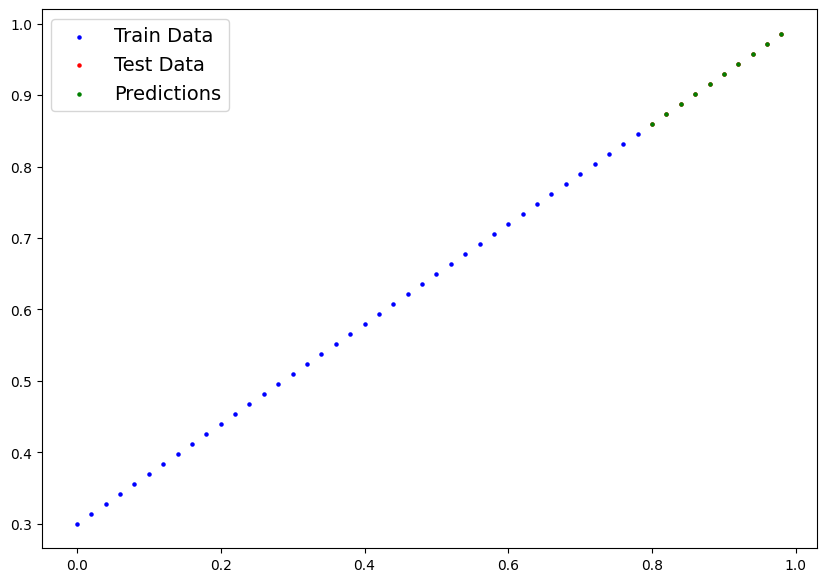

In [52]:
plot_predictions(predictions=y_preds.cpu())

### 6.5 Saving and Loading a model


In [54]:
from  pathlib import Path

# 1. Create a model Directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

# 2. Craete model save path
MODEL_SAVE_NAME = "02_PyTorch_linreg_v2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_SAVE_NAME

# 3. Save the mofel to state_dict()
print(f"Saving model to : {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)

Saving model to : models/02_PyTorch_linreg_v2.pth


In [55]:
# Load a PyTorch Model

# Create a new instance of LinearRegressionModelV2()
loaded_model_1 = LinearRegressionModelV2()

# Load the Saved model_1.state_dict()
loaded_model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Put theloaded model to device
loaded_model_1.to(device)



LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)

In [58]:
next(loaded_model_1.parameters()).device

device(type='cuda', index=0)

In [56]:
loaded_model_1.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

In [60]:
# Evaluate loaded_model_1
loaded_model_1.eval()

with torch.inference_mode():
  loaded_model_1_preds = loaded_model_1(X_test)

y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')